In [56]:
import pandas as pd
from matplotlib import pyplot as plt
cpi=pd.read_csv("inflation-of-consumer-prices.csv")
cpi.head()

,Entity,Code,Year,"Inflation, consumer prices (annual %)"
0,Australia,AUS,1960,3.728814
1,Austria,AUT,1960,1.945749
2,Belgium,BEL,1960,0.299467
3,Bolivia,BOL,1960,11.533153
4,Burkina Faso,BFA,1960,7.788162


           infl      years
23     1.779878 1960-01-01
89     1.695213 1961-01-01
157    3.632215 1962-01-01
227    2.946161 1963-01-01
297   13.355261 1964-01-01
372    9.474758 1965-01-01
455   10.801848 1966-01-01
543   13.062202 1967-01-01
634    3.237413 1968-01-01
727   -0.584137 1969-01-01
822    5.092262 1970-01-01
920    3.079939 1971-01-01
1020   6.442098 1972-01-01
1123  16.940817 1973-01-01
1227  28.598734 1974-01-01
1333   5.748430 1975-01-01
1442  -7.633948 1976-01-01
1553   8.307470 1977-01-01
1665   2.523049 1978-01-01
1776   6.275683 1979-01-01


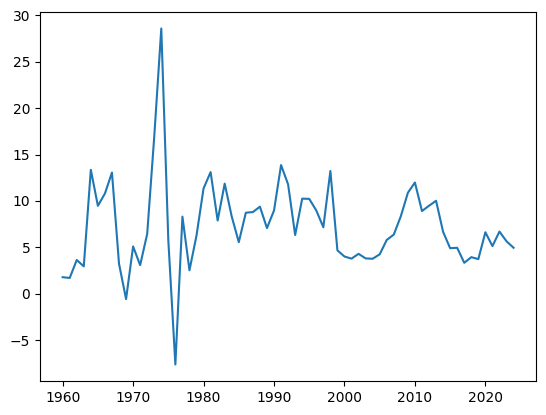

In [57]:

country="India"
data=cpi[cpi["Entity"]==country].sort_values("Year")
cp=data['Inflation, consumer prices (annual %)']
years = pd.to_datetime(data["Year"], format="%Y")
cp.head()
cp.tail()
plt.plot(years, cp)
values=pd.DataFrame({"infl":cp,"years":years})
print(values.iloc[:20])





In [58]:
from statsmodels.tsa.stattools import adfuller

diffrence=cp.dropna()
result1=adfuller(diffrence)
print(result1[0])
print(result1[1])
print({k: round(v, 2) for k, v in result1[4].items()}) 

if result1[1]<0.05:
    print("ok")
else:
    print("not ok")

-5.3051337383864885
5.343157742930871e-06
{'1%': np.float64(-3.54), '5%': np.float64(-2.91), '10%': np.float64(-2.59)}
ok


<function plot_pacf at 0x000002A6080DCCC0>
-------------


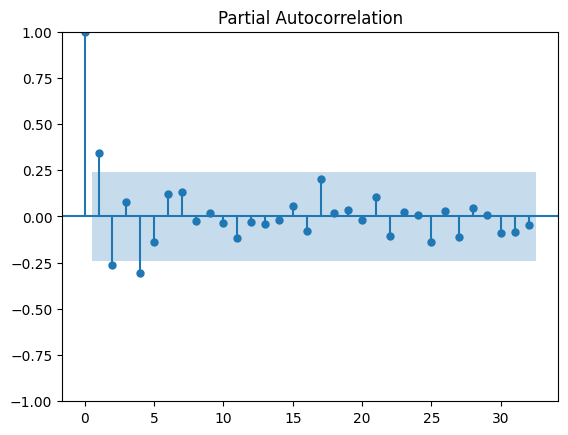

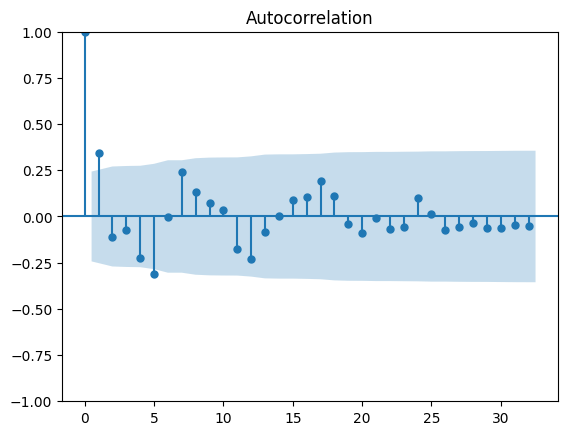

In [77]:
 from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
 plot_pacf(cp,lags=32)
 plot_acf(cp,lags=32)
 print(plot_pacf)
 print("-------------")
 plt.show(plot_acf)





p=1,2,4 q=1,5 (1,0 1) (1,0,5)(2,0,1) (2,0,5 ) (4,0,1 )(4,0,5)

Train size: 52, Test size: 13


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


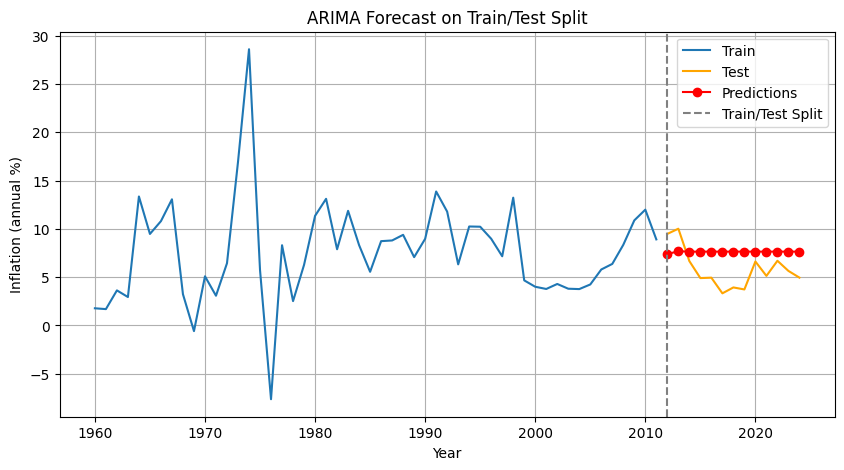

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Prepare Data ---
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
cp = data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()

# --- Train/Test Split (e.g., last 10 years for testing) ---
train_size = int(len(cp) * 0.8)   # 80% train, 20% test
train, test = cp.iloc[:train_size], cp.iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

# --- Fit ARIMA on training data ---
model = ARIMA(train, order=(1,0,1))   # change (p,d,q) as needed
result = model.fit()

# --- Forecast same length as test set ---
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end, typ="levels")
predictions.index = test.index   # align with test years

# --- Evaluate ---


# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="orange")
plt.plot(predictions.index, predictions, label="Predictions", color="red", marker="o")
plt.axvline(test.index[0], color="gray", linestyle="--", label="Train/Test Split")
plt.title("ARIMA Forecast on Train/Test Split")
plt.xlabel("Year")
plt.ylabel("Inflation (annual %)")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
values=pd.DataFrame({"test":test,"pre":predictions})
print(values)

                 test       pre
Year                           
2012-01-01   9.478997  7.383489
2013-01-01  10.017879  7.692768
2014-01-01   6.665657  7.639036
2015-01-01   4.906973  7.648371
2016-01-01   4.948216  7.646749
2017-01-01   3.328173  7.647031
2018-01-01   3.938827  7.646982
2019-01-01   3.729506  7.646991
2020-01-01   6.623437  7.646989
2021-01-01   5.131407  7.646989
2022-01-01   6.699034  7.646989
2023-01-01   5.649143  7.646989
2024-01-01   4.953035  7.646989


In [78]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, predictions))
print("Test RMSE:", rmse)

Test RMSE: 2.6720051170001113


In [79]:
# In-sample (train) predictions
train_pred = result.predict(start=0, end=len(train)-1, typ="levels")

# Train RMSE
train_rmse = np.sqrt(mean_squared_error(train, train_pred))
print("Train RMSE:", train_rmse)


Train RMSE: 4.674121135680682


Train RMSE: 4.6741
Test RMSE:  2.6720


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


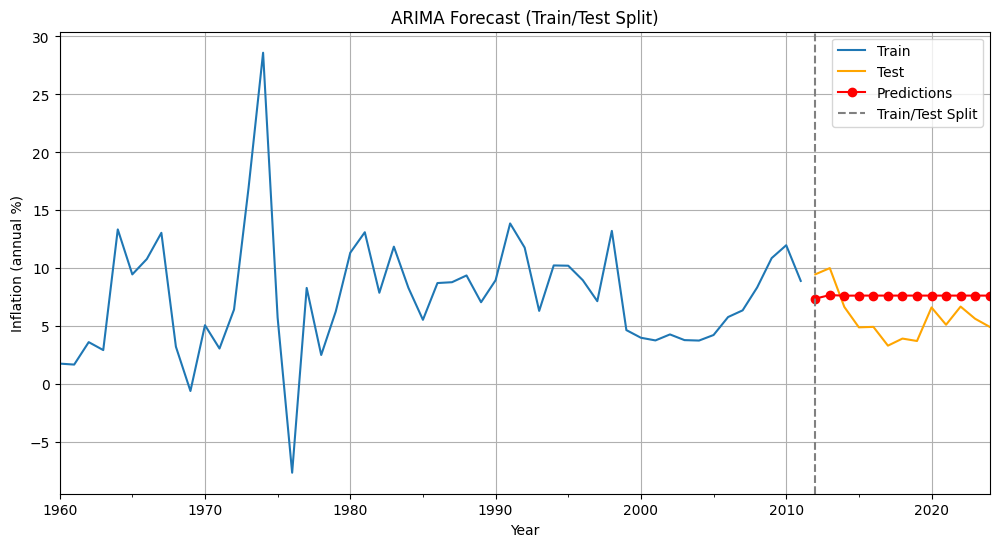

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Prepare Data ---
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
X = data[["Year"]]   # features = Year
y = data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()

# --- Train/Test Split (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=False
)

# --- Fit ARIMA on training data ---
model = ARIMA(y_train, order=(1,0,1))   # adjust (p,d,q) as needed
result = model.fit()

# --- Forecast same length as test set ---
start = len(y_train)
end = len(y_train) + len(y_test) - 1
predictions = result.predict(start=start, end=end, typ="levels")
predictions.index = X_test["Year"].values   # align with test years

# --- Evaluate ---
fitted_vals=result.fittedvalues
fitted_vals.index=y_train.index

train_rmse = np.sqrt(mean_squared_error(y_train, fitted_vals))
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE:  {test_rmse:.4f}")

# --- Plot ---
plt.figure(figsize=(12,6))
y_train.index = X_train["Year"].values
y_test.index = X_test["Year"].values
y_train.plot(label="Train")
y_test.plot(label="Test", color="orange")
predictions.plot(label="Predictions", color="red", marker="o")
plt.axvline(y_test.index[0], color="gray", linestyle="--", label="Train/Test Split")
plt.title("ARIMA Forecast (Train/Test Split)")
plt.xlabel("Year")
plt.ylabel("Inflation (annual %)")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, predictions))
print("Test RMSE:", rmse)

Test RMSE: 2.6720051170001113


In [93]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, predictions))
print("Test RMSE:", rmse)

Test RMSE: 2.6720051170001113


In [84]:
values=pd.DataFrame({"test":test,"pre":predictions})
print(values)

                 test       pre
2012-01-01   9.478997  7.035809
2013-01-01  10.017879  6.185575
2014-01-01   6.665657  5.747237
2015-01-01   4.906973  7.595657
2016-01-01   4.948216  9.587070
2017-01-01   3.328173  9.361491
2018-01-01   3.938827  8.708960
2019-01-01   3.729506  8.521834
2020-01-01   6.623437  7.185972
2021-01-01   5.131407  5.624360
2022-01-01   6.699034  6.080631
2023-01-01   5.649143  7.456474
2024-01-01   4.953035  8.052700


In [81]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# --- Prepare Data ---
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
y = data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()

# --- Train/Test Split (80% train, 20% test) ---
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- Parameter grid ---
p_values = [1, 2, 4]
d_values = [0]
q_values = [1, 5]

results = []

# --- Grid Search ---
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit model
                model = ARIMA(y_train, order=(p, d, q))
                result = model.fit()
                
                # Forecast test period
                start = len(y_train)
                end = len(y_train) + len(y_test) - 1
                predictions = result.predict(start=start, end=end, typ="levels")
                predictions.index = y_test.index
                
                # Compute RMSE
                rmse = np.sqrt(mean_squared_error(y_test, predictions))
                
                # Save results
                results.append({
                    "order": (p,d,q),
                    "aic": result.aic,
                    "bic": result.bic,
                    "rmse": rmse
                })
                
                print(f"ARIMA({p},{d},{q}) -> AIC={result.aic:.2f}, BIC={result.bic:.2f}, RMSE={rmse:.4f}")
            
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results).sort_values("rmse")
print("\nSorted results by RMSE:\n", results_df)


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-pa

ARIMA(1,0,1) -> AIC=315.90, BIC=323.70, RMSE=2.6720
ARIMA(1,0,5) -> AIC=317.00, BIC=332.61, RMSE=2.9197


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-pa

ARIMA(2,0,1) -> AIC=317.40, BIC=327.16, RMSE=2.7129
ARIMA(2,0,5) -> AIC=319.09, BIC=336.66, RMSE=2.7972


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


ARIMA(4,0,1) -> AIC=314.76, BIC=328.42, RMSE=2.9953
ARIMA(4,0,5) -> AIC=318.92, BIC=340.38, RMSE=3.3534

Sorted results by RMSE:
        order         aic         bic      rmse
0  (1, 0, 1)  315.896936  323.701911  2.672005
2  (2, 0, 1)  317.399922  327.156140  2.712875
3  (2, 0, 5)  319.094879  336.656073  2.797170
1  (1, 0, 5)  316.995966  332.605916  2.919707
4  (4, 0, 1)  314.763983  328.422689  2.995334
5  (4, 0, 5)  318.917540  340.381220  3.353356


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# --- Prepare Data ---
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
y = data.set_index("Year")["Inflation, consumer prices (annual %)"].dropna()

# --- Train/Test Split (80% train, 20% test) ---
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# --- Parameter grid ---
p_values = [1, 2, 4]
d_values = [0]
q_values = [1, 5]

results = []

# --- Grid Search ---
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit model
                model = ARIMA(y_train, order=(p, d, q))
                result = model.fit()
                
                # --- Train RMSE ---
                train_pred = result.predict(start=0, end=len(y_train)-1, typ="levels")
                train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
                
                # --- Test RMSE ---
                start = len(y_train)
                end = len(y_train) + len(y_test) - 1
                predictions = result.predict(start=start, end=end, typ="levels")
                predictions.index = y_test.index
                test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
                
                # Save results
                results.append({
                    "order": (p,d,q),
                    "aic": result.aic,
                    "bic": result.bic,
                    "train_rmse": train_rmse,
                    "test_rmse": test_rmse,
                    "rmse_gap": train_rmse - test_rmse
                })
                
                print(f"ARIMA({p},{d},{q}) -> Train RMSE={train_rmse:.4f}, "
                      f"Test RMSE={test_rmse:.4f}, Gap={test_rmse-train_rmse:.4f}, "
                      f"AIC={result.aic:.2f}, BIC={result.bic:.2f}")
            
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results).sort_values("test_rmse")

print("\nSorted results by Test RMSE:\n", results_df)


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-pa

ARIMA(1,0,1) -> Train RMSE=4.6741, Test RMSE=2.6720, Gap=-2.0021, AIC=315.90, BIC=323.70


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\t

ARIMA(1,0,5) -> Train RMSE=4.3938, Test RMSE=2.9197, Gap=-1.4741, AIC=317.00, BIC=332.61
ARIMA(2,0,1) -> Train RMSE=4.6522, Test RMSE=2.7129, Gap=-1.9394, AIC=317.40, BIC=327.16
ARIMA(2,0,5) -> Train RMSE=4.3821, Test RMSE=2.7972, Gap=-1.5849, AIC=319.09, BIC=336.66


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-pa

ARIMA(4,0,1) -> Train RMSE=4.3673, Test RMSE=2.9953, Gap=-1.3719, AIC=314.76, BIC=328.42
ARIMA(4,0,5) -> Train RMSE=4.2256, Test RMSE=3.3534, Gap=-0.8722, AIC=318.92, BIC=340.38

Sorted results by Test RMSE:
        order         aic         bic  train_rmse  test_rmse  rmse_gap
0  (1, 0, 1)  315.896936  323.701911    4.674121   2.672005  2.002116
2  (2, 0, 1)  317.399922  327.156140    4.652232   2.712875  1.939357
3  (2, 0, 5)  319.094879  336.656073    4.382118   2.797170  1.584947
1  (1, 0, 5)  316.995966  332.605916    4.393813   2.919707  1.474105
4  (4, 0, 1)  314.763983  328.422689    4.367256   2.995334  1.371923
5  (4, 0, 5)  318.917540  340.381220    4.225585   3.353356  0.872229


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\leston\miniconda3\envs\time\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\leston\AppData\Local\Temp\ipykernel_22596\542339512.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast.index=pd.date_range(start=str(last_year+1), periods=12,freq="Y")


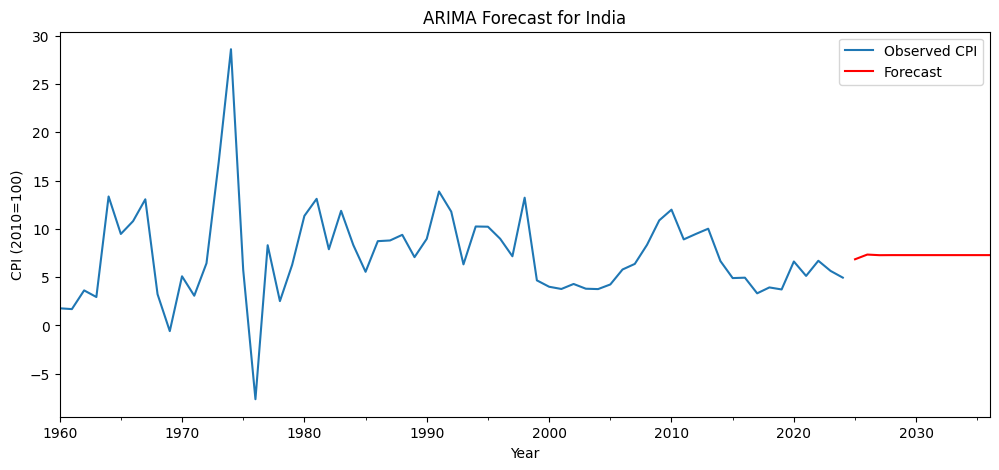

In [89]:
model=ARIMA(y, order=(1,0,1))
result=model.fit()
forecast=result.predict(start=len(y),end=len(y)+12-1,)
last_year=y.index[-1].year
forecast.index=pd.date_range(start=str(last_year+1), periods=12,freq="Y")
#inflation=forecast.pct_change()*100
#inflation.iloc[0] = ((forecast.iloc[0]-y.iloc[-1])/y.iloc[-1])*100
plt.figure(figsize=(12,5))
y.plot(label="Observed CPI")
forecast.plot(label="Forecast", color="red")
plt.title(f"ARIMA Forecast for {country}")
plt.xlabel("Year")
plt.ylabel("CPI (2010=100)")
plt.legend()
plt.show()


In [90]:
forecast_df=pd.DataFrame({"Year":forecast.index,"Forecasted CPI":forecast.values})
print(forecast_df)

         Year  Forecasted CPI
0  2025-12-31        6.854117
1  2026-12-31        7.341141
2  2027-12-31        7.276970
3  2028-12-31        7.285425
4  2029-12-31        7.284311
5  2030-12-31        7.284458
6  2031-12-31        7.284438
7  2032-12-31        7.284441
8  2033-12-31        7.284441
9  2034-12-31        7.284441
10 2035-12-31        7.284441
11 2036-12-31        7.284441
